In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
import os
sys.path.append('../python/')

#set up matplotlib
os.environ['MPLCONFIGDIR'] = '../mplstyles'
print(os.environ['MPLCONFIGDIR'])
import matplotlib as mpl
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')
print(mpl.__version__) 
print(mpl.get_configdir())


#fonts
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'32'}
legend_font = {'fontname':'Arial', 'size':'22'}

#fonts global settings
mpl.rc('font',family=legend_font['fontname'])


#set up numpy
import numpy as np

../mplstyles
3.0.3
/home/phys/villaa/analysis/misc/nrFano_Constraint/mplstyles


# Summary

We know that the Dogherty paper [[Dough92][Dough92]] has measured the ionization variance for nuclear recoils in silicon. And that this paper has compared to results to the Lindhard description (J. Lindhard _et al_., Mat. Fys. Medd. K. Dan. Vidensk. Selsk **33**, 10 (1963)). The purpose of this note is to recast these results in terms of the effective Fano factor and make it clear where we got the information from, and how the data was processed. 

[Dough92]: https://journals.aps.org/pra/abstract/10.1103/PhysRevA.45.2104 "Dougherty paper 1992"

# Extracting the Lindhard Function(s)

In the Lindhard reference above (J. Lindhard _et al_., Mat. Fys. Medd. K. Dan. Vidensk. Selsk **33**, 10 (1963)), Figure 8 contains the information we need and is reproduced below. 

<img src="pics/lindhard2_curves.png" alt="Lindhard ionization variance" style="width: 600px;"/>

The red and green curves report the fractional variance $(\Omega/\epsilon)^2$ in phonon (heat) energy produced by a nucleus with a given initial non-dimensionalized energy $\epsilon$. From the `pdf` file for the publication listed we extracted the curves by first using `inkscape` to draw colored Bezier curves over the curves of interested and then extracting the `svg` points for those curves from the resulting saved `svg` figure. 

For now instead of using the `svg` extraction, we are using `DataThief` to extract the colored curves. The results are shown below.

In [3]:
import dataPython as dp
import numpy as np

lind_data0 = dp.getXYdata('data/lindhard2_OmegaepsD_fmt.txt')
lind_data1 = dp.getXYdata('data/lindhard2_OmegaepsE_fmt.txt')

lindD_e = np.asarray(lind_data0['xx'])
lindD = np.asarray(lind_data0['yy'])
lindE_e = np.asarray(lind_data1['xx'])
lindE = np.asarray(lind_data1['yy'])

print(np.min(np.diff(lindD_e)))
print(np.min(np.diff(lindE_e)))

0.0
0.0


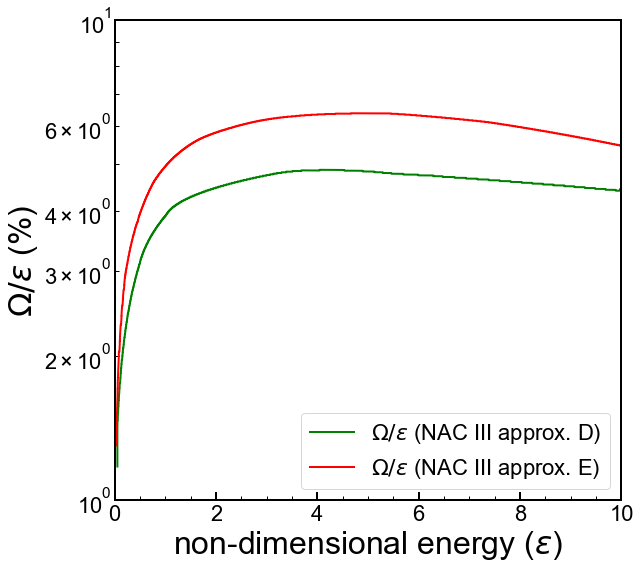

In [9]:


#set up a plot

fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

xmax=10

#ax1.errorbar(ddata_e,ddata_fluct,yerr=[ddata_fluct_err,ddata_fluct_err], marker='o', markersize=8, \
#             ecolor='k',color='k', linestyle='none', label='Dougherty Excess Fluctuation', linewidth=2)


#ax1.plot (X, diff, 'm-', label='Thomas-Fermi (newgrad)')
#ax1.plot (Esi(epr), 100*np.sqrt(f_Omega2_eta2(epr))*ylindv(1000*Esi(epr)), 'g-', label='$\Omega/\epsilon$ (NAC III approx. D)')
ax1.plot (lindD_e, np.sqrt(lindD)*100, 'g-', label='$\Omega/\epsilon$ (NAC III approx. D)')
ax1.plot (lindE_e, np.sqrt(lindE)*100, 'r-', label='$\Omega/\epsilon$ (NAC III approx. E)')




ax1.set_yscale('log')
ax1.set_xscale('linear')
ax1.set_xlim(0.0, xmax)
ax1.set_ylim(1,10)
ax1.set_xlabel('non-dimensional energy ($\epsilon$)',**axis_font)
ax1.set_ylabel('$\Omega/\epsilon$ (%)',**axis_font)
#ax1.grid(True)
#ax1.xaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=4,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()

